[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danny024/reservoir_pinn_simulator/blob/main/reservoir_pinn_notebook.ipynb)

## 3D Reservoir PINN Simulator

This Jupyter Notebook explains the Python code implementation for a Physics-Informed Neural Network (PINN) that simulates pressure in a 3D reservoir. The code solves a 3D partial differential equation (PDE) for single-phase fluid flow, incorporating data from a CSV file, boundary conditions, and initial conditions. It as well includes static 2D slice visualizations and an animation of the pressure field.

### Prerequisites
- Python 3.8+
- Required libraries: `torch`, `numpy`, `pandas`, `matplotlib`, `ffmpeg-python`
- FFmpeg installed for animation rendering
- A sample `data/reservoir_data.csv` file with columns `x`, `y`, `z`, `t`, `p` (provided with 50 points)

### Overview
The code:
1. Defines reservoir parameters and a PINN model for 3D input (x, y, z, t).
2. Computes the PDE residual for the 3D flow equation.
3. Loads sparse data from `data/reservoir_data.csv`.
4. Generates collocation, boundary, and initial condition points in 3D.
5. Trains the PINN using Adam and L-BFGS optimizers.
6. Validates the model and visualizes results (2D slices and animation).
7. Plots the PINN architecture.

The PDE is:

$$
\phi\,c_t\,\frac{\partial p}{\partial t}
\;-\;
\frac{k}{\mu}\Biggl(
  \frac{\partial^2 p}{\partial x^2}
  + \frac{\partial^2 p}{\partial y^2}
  + \frac{\partial^2 p}{\partial z^2}
\Biggr)
\;=\;q
$$

where the source term is

$$
q = q_0 \exp\!\Biggl(
  -\frac{(x - x_w)^2 + (y - y_w)^2 + (z - z_w)^2}{2\,\sigma^2}
\Biggr).
$$


### Boundary Conditions (BC)

No-flow (Neumann) conditions are applied on the domain boundaries ($x=0,1$, $y=0,1$, $z=0,1$):

$$
\frac{\partial p}{\partial n} = 0
$$



### Initial Conditions (IC)

A uniform pressure is set at $t=0$:

$$
p(x, y, z, 0) = p_{\text{base}}
$$


### 1. Import Libraries

This cell imports the necessary libraries for numerical computations, neural networks, data handling, visualization, and animation.

In [24]:
%pip install torch numpy pandas matplotlib ffmpeg-python

Note: you may need to restart the kernel to use updated packages.



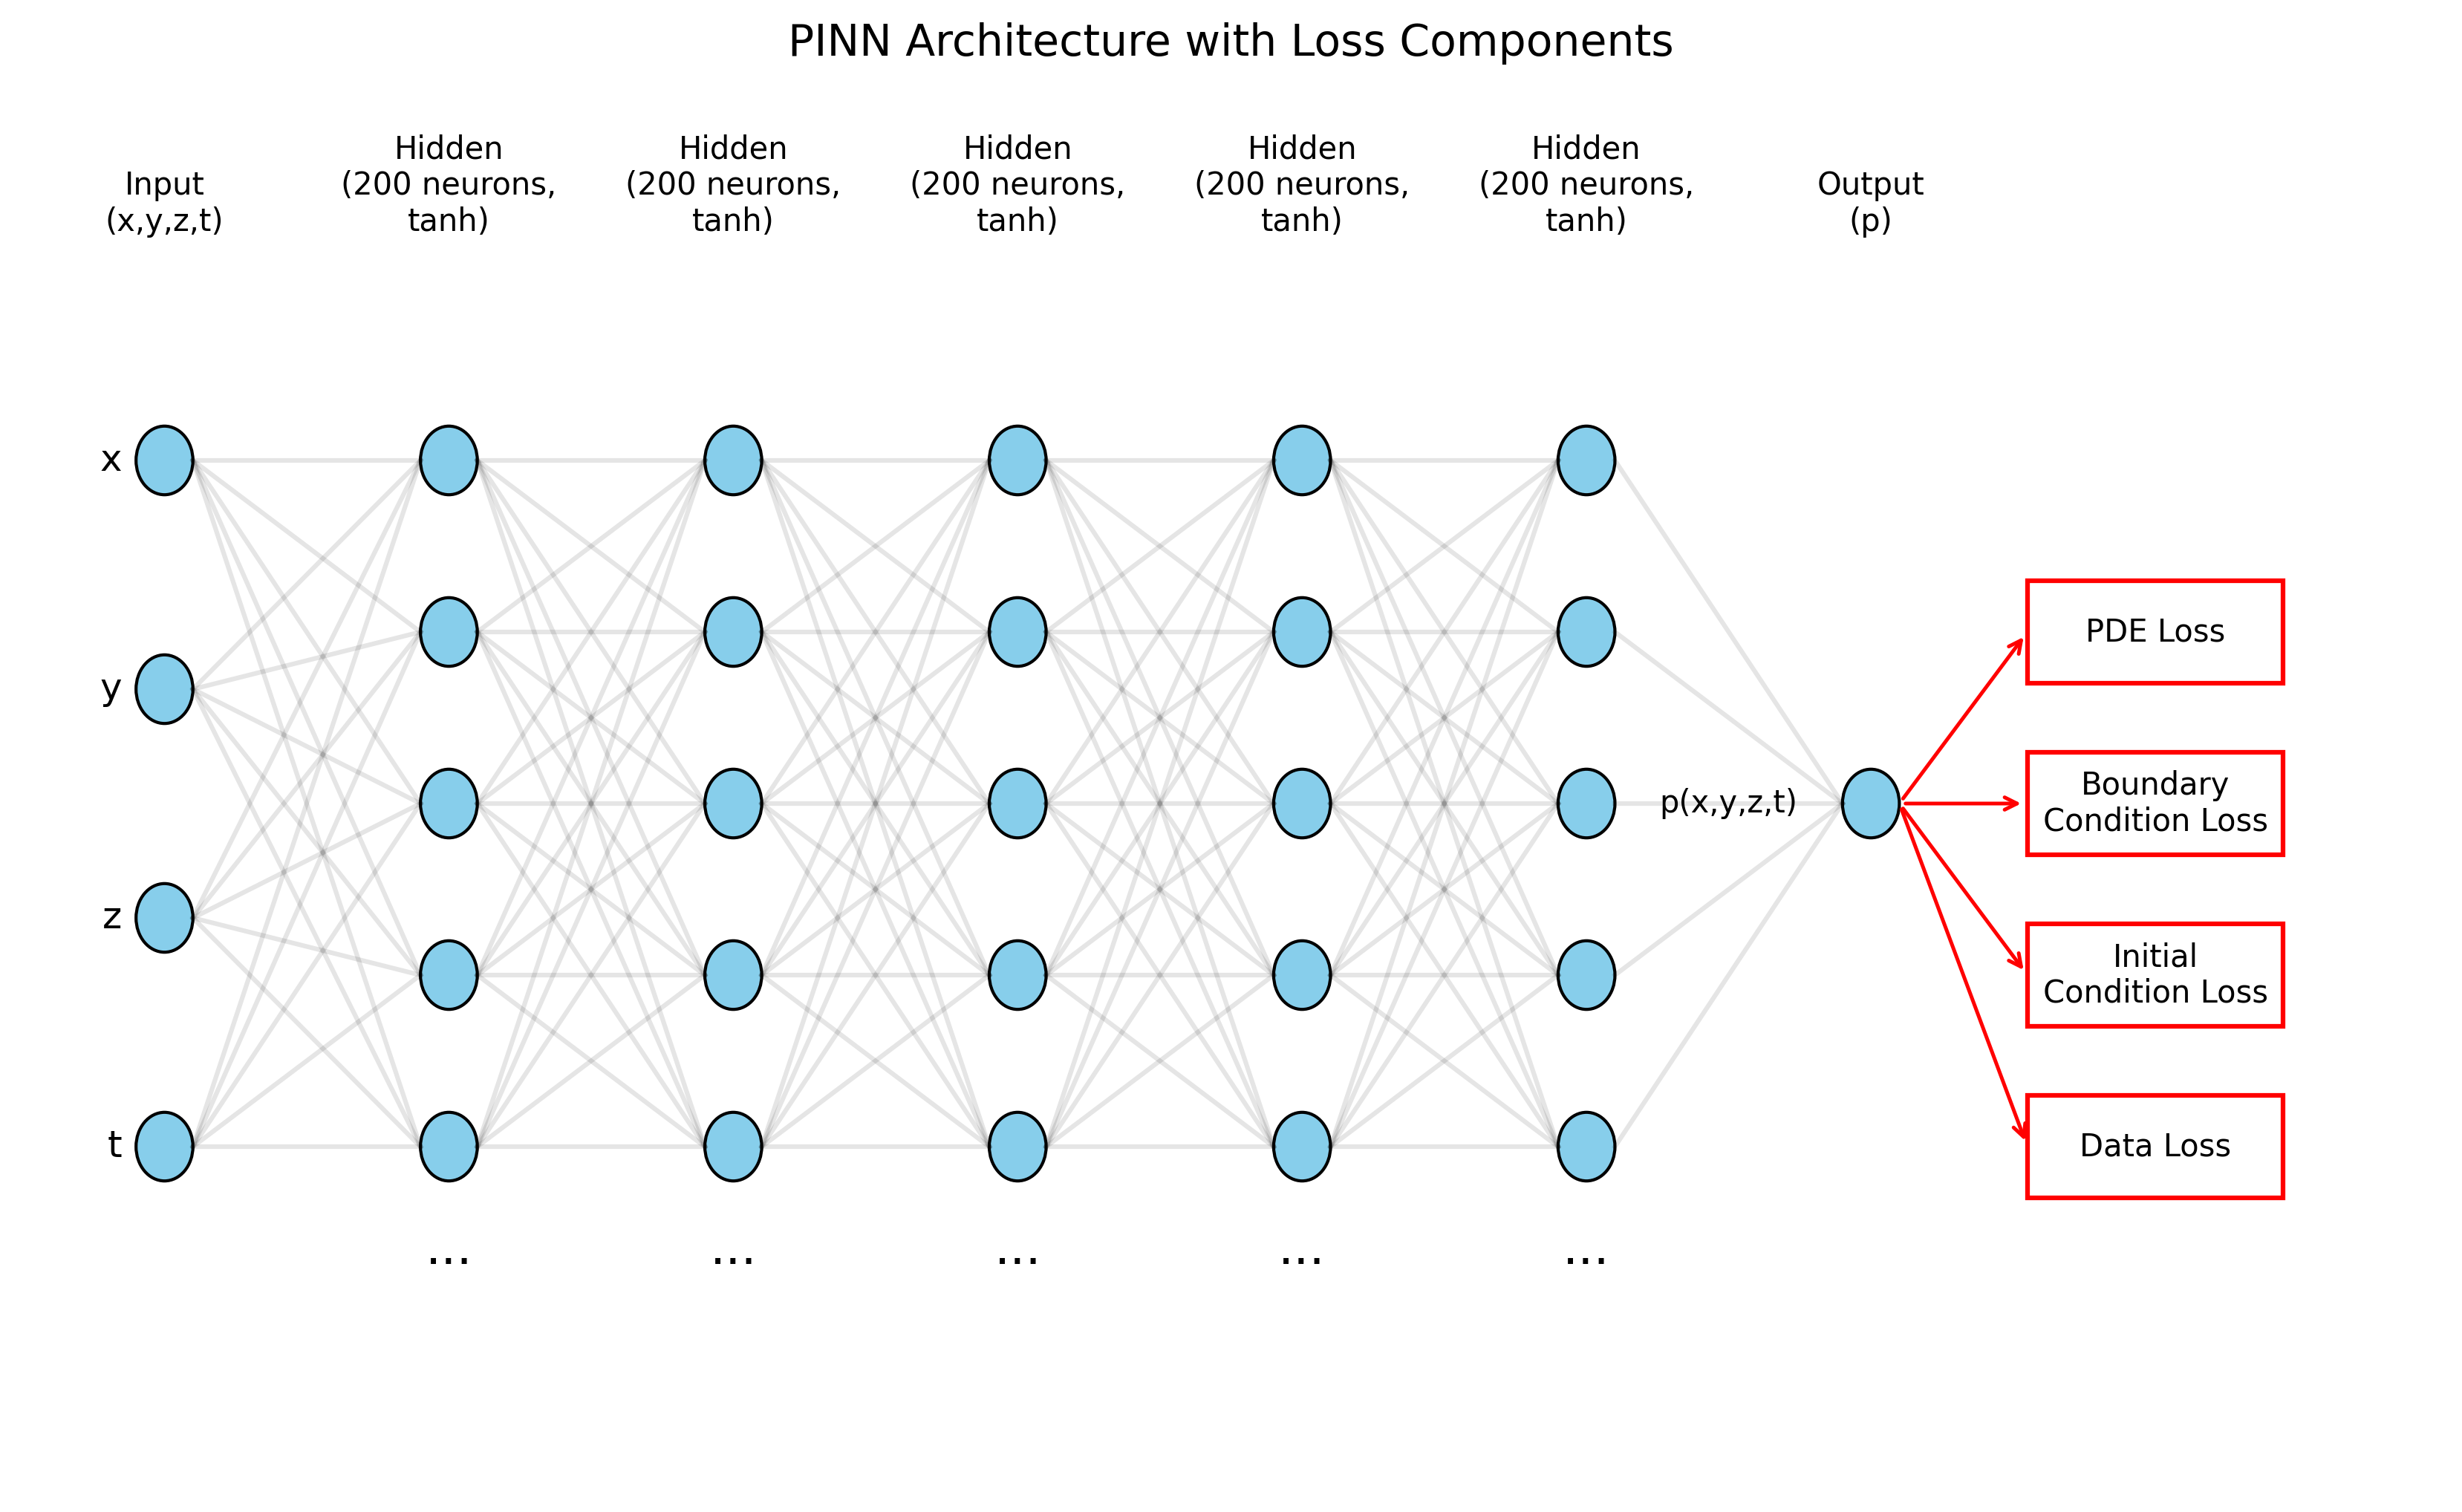

In [38]:
import base64
from IPython.display import HTML

# Read the image and encode it as Base64
with open('pinn_architecture.png', 'rb') as f:
    img_data = f.read()
img_base64 = base64.b64encode(img_data).decode('utf-8')

# Display the image using HTML with reduced size
HTML(f'<img src="data:image/png;base64,{img_base64}" alt="PINN Architecture" width="600" height="400" />')

In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image
import base64


### 2. Set Random Seed and Device

This cell ensures reproducibility by setting random seeds and configures the device (GPU or CPU) for computations.

In [26]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### 3. Define Reservoir Parameters

This cell defines the physical parameters of the 3D reservoir and the simulation.

In [27]:
# Reservoir parameters
phi = 0.2  # Porosity
k = 0.1  # Permeability (Darcy)
mu = 1.0  # Viscosity (cP)
ct = 1e-6  # Total compressibility (1/Pa)
q0 = 0.01  # Injection rate (m^3/s)
well_pos = (0.5, 0.5, 0.5)  # Well location in 3D
p_base = 1000.0  # Base pressure (Pa)
p_scale = 1000.0  # Scale for normalization

# Explanation:
# - phi: Porosity, fraction of pore volume (0.2).
# - k: Permeability, ease of fluid flow (0.1 Darcy).
# - mu: Fluid viscosity (1.0 cP).
# - ct: Total compressibility (1e-6 1/Pa), accounts for fluid and rock.
# - q0: Injection rate at the well (0.01 m^3/s).
# - well_pos: Coordinates of the injection well (0.5, 0.5, 0.5) in 3D.
# - p_base: Initial/base pressure (1000 Pa).
# - p_scale: Scaling factor for pressure normalization (1000 Pa).

### 4. Define PINN Model

This cell defines the PINN neural network architecture with 8 layers, accepting 4 inputs (x, y, z, t).

In [28]:
# Neural network architecture (8 layers, 200 neurons)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 200),  # 4 inputs: x, y, z, t
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )
    
    def forward(self, x):
        return self.net(x) * p_scale + p_base  # Scale and shift output

# Explanation:
# - PINN: Inherits from nn.Module, defining a neural network.
# - __init__: Constructs an 8-layer network:
#   - Input layer: 4 inputs (x, y, z, t) for 3D spatial and temporal coordinates.
#   - 6 hidden layers: 200 neurons each, with Tanh activation.
#   - Output layer: 1 output (pressure p).
# - forward: Computes the network output, scaling by p_scale (1000) and shifting by p_base (1000).

### 5. Compute PDE Residual

This cell defines a function to compute the residual of the 3D PDE.

In [29]:
# Function to compute PDE residual
def compute_pde_residual(model, x, y, z, t):
    inputs = torch.stack([x, y, z, t], dim=1).requires_grad_(True).to(device)
    p = model(inputs)
    
    # Compute gradients
    p_grad = torch.autograd.grad(p, inputs, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_x, p_y, p_z, p_t = p_grad[:, 0], p_grad[:, 1], p_grad[:, 2], p_grad[:, 3]
    
    # Second derivatives
    p_xx = torch.autograd.grad(p_x, inputs, grad_outputs=torch.ones_like(p_x), create_graph=True)[0][:, 0]
    p_yy = torch.autograd.grad(p_y, inputs, grad_outputs=torch.ones_like(p_y), create_graph=True)[0][:, 1]
    p_zz = torch.autograd.grad(p_z, inputs, grad_outputs=torch.ones_like(p_z), create_graph=True)[0][:, 2]
    
    # Source term
    sigma = 0.05
    q = q0 * torch.exp(-((x - well_pos[0])**2 + (y - well_pos[1])**2 + (z - well_pos[2])**2) / (2 * sigma**2))
    
    # PDE: phi * ct * dp/dt - (k/mu) * (d^2p/dx^2 + d^2p/dy^2 + d^2p/dz^2) = q
    residual = phi * ct * p_t - (k / mu) * (p_xx + p_yy + p_zz) - q
    return residual

# Explanation:
# - compute_pde_residual: Computes the residual of the 3D PDE.
# - inputs: Combines x, y, z, t into a tensor, with requires_grad=True for differentiation.
# - p: Predicted pressure from the PINN model.
# - p_grad: Computes first derivatives (p_x, p_y, p_z, p_t) using autograd.
# - p_xx, p_yy, p_zz: Computes second derivatives for the 3D Laplacian.
# - q: 3D Gaussian source term centered at well_pos.
# - residual: PDE residual, minimized to enforce the physical law.

### 6. Load Sparse Dataset

This cell loads the 3D pressure data from `data/reservoir_data.csv`.

In [30]:
# Load sparse dataset from CSV
try:
    data_df = pd.read_csv("data/reservoir_data.csv")
    if not all(col in data_df.columns for col in ['x', 'y', 'z', 't', 'p']):
        raise ValueError("CSV file must contain columns: x, y, z, t, p")
    data = torch.tensor(data_df[['x', 'y', 'z', 't', 'p']].values, dtype=torch.float32).to(device)
except FileNotFoundError:
    print("Error: 'data/reservoir_data.csv' not found. Please provide the CSV file.")
    exit(1)
except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit(1)

x_d, y_d, z_d, t_d, p_d = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]
N_d = len(data)

# Explanation:
# - data_df: Reads 'data/reservoir_data.csv' with 50 points (5 original, 45 augmented).
# - Validation: Ensures columns x, y, z, t, p exist.
# - data: Converts DataFrame to a PyTorch tensor, moved to device.
# - x_d, y_d, z_d, t_d, p_d: Extracts 3D coordinates, time, and pressure.
# - N_d: Number of data points (50).
# - Error handling: Exits on file not found or invalid format.

### 7. Generate Collocation Points

This cell generates 3D points for PDE, boundary, and initial conditions.

In [31]:
# Generate collocation points with adaptive sampling
N_r = 20000  # Collocation points
N_b = 2000   # Boundary points
N_i = 2000   # Initial condition points
N_r_adaptive = 10000  # Adaptive points

# Random collocation points
x_r = torch.rand(N_r).to(device)
y_r = torch.rand(N_r).to(device)
z_r = torch.rand(N_r).to(device)
t_r = torch.rand(N_r).to(device)

# Adaptive sampling near well position
x_r_adaptive = torch.normal(mean=0.5, std=0.1, size=(N_r_adaptive,)).clamp(0, 1).to(device)
y_r_adaptive = torch.normal(mean=0.5, std=0.1, size=(N_r_adaptive,)).clamp(0, 1).to(device)
z_r_adaptive = torch.normal(mean=0.5, std=0.1, size=(N_r_adaptive,)).clamp(0, 1).to(device)
t_r_adaptive = torch.rand(N_r_adaptive).to(device)

x_r = torch.cat([x_r, x_r_adaptive])
y_r = torch.cat([y_r, y_r_adaptive])
z_r = torch.cat([z_r, z_r_adaptive])
t_r = torch.cat([t_r, t_r_adaptive])

# Boundary points (faces of the cube)
N_b_per_face = N_b // 6  # ~333 points per face
remainder = N_b % 6  # Distribute remainder to ensure exact N_b
face_counts = [N_b_per_face + 1 if i < remainder else N_b_per_face for i in range(6)]

# x=0 and x=1 faces
x_b = torch.cat([
    torch.zeros(face_counts[0]),  # x=0
    torch.ones(face_counts[1]),   # x=1
    torch.rand(face_counts[2]),   # y=0
    torch.rand(face_counts[3]),   # y=1
    torch.rand(face_counts[4]),   # z=0
    torch.rand(face_counts[5])    # z=1
]).to(device)

# y=0 and y=1 faces
y_b = torch.cat([
    torch.rand(face_counts[0]),   # x=0
    torch.rand(face_counts[1]),   # x=1
    torch.zeros(face_counts[2]),  # y=0
    torch.ones(face_counts[3]),   # y=1
    torch.rand(face_counts[4]),   # z=0
    torch.rand(face_counts[5])    # z=1
]).to(device)

# z=0 and z=1 faces
z_b = torch.cat([
    torch.rand(face_counts[0]),   # x=0
    torch.rand(face_counts[1]),   # x=1
    torch.rand(face_counts[2]),   # y=0
    torch.rand(face_counts[3]),   # y=1
    torch.zeros(face_counts[4]),  # z=0
    torch.ones(face_counts[5])    # z=1
]).to(device)

# Random time for all boundary points
t_b = torch.rand(N_b).to(device)

# Initial condition points
x_i = torch.rand(N_i).to(device)
y_i = torch.rand(N_i).to(device)
z_i = torch.rand(N_i).to(device)
t_i = torch.zeros(N_i).to(device)
# Explanation:
# - N_r, N_b, N_i, N_r_adaptive: Number of points for PDE, boundaries, initial conditions, and adaptive sampling.
# - Collocation points: Randomly sampled in [0,1]^3 for x, y, z, and t for PDE enforcement.
# - Adaptive points: Sampled near well (0.5, 0.5, 0.5) to focus on injection region.
# - Boundary points: Sampled on cube faces (x=0,1; y=0,1; z=0,1) with random t.
# - Initial condition points: Random x, y, z with t=0.
# - All tensors are moved to device.

### 8. Initialize Model and Optimizer

This cell initializes the PINN model and sets up the Adam optimizer.

In [32]:
# Initialize model and optimizer
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2000, gamma=0.5)

# Explanation:
# - model: Instantiates the 3D PINN model and moves it to device.
# - optimizer: Uses Adam optimizer with learning rate 0.001.
# - scheduler: Reduces learning rate by half every 2000 epochs.

### 9. Training Loop (Adam)

This cell trains the PINN using Adam, minimizing the loss.

In [33]:
# Training loop (Adam)
losses_pde = []
losses_bc = []
losses_ic = []
losses_data = []
losses_total = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # PDE residual loss
    residual = compute_pde_residual(model, x_r, y_r, z_r, t_r)
    loss_pde = torch.mean(residual**2)
    
    # Boundary condition loss
    inputs_b = torch.stack([x_b, y_b, z_b, t_b], dim=1).requires_grad_(True).to(device)
    p_b = model(inputs_b)
    p_grad_b = torch.autograd.grad(p_b, inputs_b, grad_outputs=torch.ones_like(p_b), create_graph=True)[0]
    p_x_b, p_y_b, p_z_b = p_grad_b[:, 0], p_grad_b[:, 1], p_grad_b[:, 2]
    
    mask_x0 = (x_b == 0)
    mask_x1 = (x_b == 1)
    loss_bc_x = torch.mean(p_x_b[mask_x0]**2) + torch.mean(p_x_b[mask_x1]**2)
    
    mask_y0 = (y_b == 0)
    mask_y1 = (y_b == 1)
    loss_bc_y = torch.mean(p_y_b[mask_y0]**2) + torch.mean(p_y_b[mask_y1]**2)
    
    mask_z0 = (z_b == 0)
    mask_z1 = (z_b == 1)
    loss_bc_z = torch.mean(p_z_b[mask_z0]**2) + torch.mean(p_z_b[mask_z1]**2)
    
    loss_bc = loss_bc_x + loss_bc_y + loss_bc_z
    
    # Initial condition loss
    inputs_i = torch.stack([x_i, y_i, z_i, t_i], dim=1).to(device)
    p_i = model(inputs_i)
    loss_ic = torch.mean(((p_i - p_base) / p_scale)**2)
    
    # Data loss
    inputs_d = torch.stack([x_d, y_d, z_d, t_d], dim=1).to(device)
    p_d_pred = model(inputs_d)
    loss_data = torch.mean(((p_d_pred - p_d) / p_scale)**2)
    
    # Total loss
    loss = loss_pde + 100 * loss_bc + 10000 * loss_ic + 1000000 * loss_data  # we give more weight to the data loss
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Store losses
    losses_pde.append(loss_pde.item())
    losses_bc.append(loss_bc.item())
    losses_ic.append(loss_ic.item())
    losses_data.append(loss_data.item())
    losses_total.append(loss.item())
    
    # Residual-based adaptive sampling
    if (epoch + 1) % 1000 == 0:
        residual_abs = torch.abs(residual)
        top_indices = torch.topk(residual_abs, k=1000).indices
        x_r = torch.cat([x_r, x_r[top_indices]])
        y_r = torch.cat([y_r, y_r[top_indices]])
        z_r = torch.cat([z_r, z_r[top_indices]])
        t_r = torch.cat([t_r, t_r[top_indices]])
    
    if (epoch + 1) % 1000 == 0:
        with torch.no_grad():
            p_d_pred = model(inputs_d)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, "
                  f"PDE: {loss_pde.item():.6f}, BC: {loss_bc.item():.6f}, "
                  f"IC: {loss_ic.item():.6f}, Data: {loss_data.item():.6f}")
            print("Predicted vs Actual pressures:")
            for i in range(N_d):
                print(f"Point {i+1}: Predicted={p_d_pred[i].item():.2f}, Actual={p_d[i].item():.2f}")

# Explanation of Cell:
# - epochs: Trains for 20,000 iterations.
# - loss_pde: Mean squared PDE residual in 3D.
# - loss_bc: Enforces no-flow conditions on all cube faces.
# - loss_ic: Enforces initial pressure p_base.
# - loss_data: Matches predictions to the 50-point dataset.
# - loss: Weighted sum of losses to balance contributions.
# - Adaptive sampling: Adds points with high residual every 1000 epochs.
# - Logging: Prints loss components and predictions every 1000 epochs.

Epoch [1000/20000], Loss: 21.574986, PDE: 0.000010, BC: 0.000088, IC: 0.000137, Data: 0.000020
Predicted vs Actual pressures:
Point 1: Predicted=1012.01, Actual=1010.00
Point 2: Predicted=1012.13, Actual=1020.00
Point 3: Predicted=1011.89, Actual=1005.00
Point 4: Predicted=1012.25, Actual=1015.00
Point 5: Predicted=1011.95, Actual=1008.00
Point 6: Predicted=1011.78, Actual=1018.20
Point 7: Predicted=1011.83, Actual=1019.50
Point 8: Predicted=1011.89, Actual=1007.80
Point 9: Predicted=1011.95, Actual=1009.30
Point 10: Predicted=1012.01, Actual=1016.70
Point 11: Predicted=1012.07, Actual=1017.90
Point 12: Predicted=1012.13, Actual=1006.40
Point 13: Predicted=1012.19, Actual=1012.10
Point 14: Predicted=1012.25, Actual=1018.80
Point 15: Predicted=1012.31, Actual=1008.50
Point 16: Predicted=1011.81, Actual=1019.10
Point 17: Predicted=1011.86, Actual=1007.20
Point 18: Predicted=1011.92, Actual=1013.40
Point 19: Predicted=1011.98, Actual=1017.60
Point 20: Predicted=1012.04, Actual=1010.90
Poi

### 10. L-BFGS Optimization

This cell refines the model using L-BFGS.

In [17]:
# L-BFGS optimization
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
def closure():
    optimizer.zero_grad()
    residual = compute_pde_residual(model, x_r, y_r, z_r, t_r)
    loss_pde = torch.mean(residual**2)
    inputs_b = torch.stack([x_b, y_b, z_b, t_b], dim=1).requires_grad_(True).to(device)
    p_b = model(inputs_b)
    p_grad_b = torch.autograd.grad(p_b, inputs_b, grad_outputs=torch.ones_like(p_b), create_graph=True)[0]
    p_x_b, p_y_b, p_z_b = p_grad_b[:, 0], p_grad_b[:, 1], p_grad_b[:, 2]
    loss_bc_x = torch.mean(p_x_b[(x_b == 0)]**2) + torch.mean(p_x_b[(x_b == 1)]**2)
    loss_bc_y = torch.mean(p_y_b[(y_b == 0)]**2) + torch.mean(p_y_b[(y_b == 1)]**2)
    loss_bc_z = torch.mean(p_z_b[(z_b == 0)]**2) + torch.mean(p_z_b[(z_b == 1)]**2)
    loss_bc = loss_bc_x + loss_bc_y + loss_bc_z
    inputs_i = torch.stack([x_i, y_i, z_i, t_i], dim=1).to(device)
    p_i = model(inputs_i)
    loss_ic = torch.mean(((p_i - p_base) / p_scale)**2)
    inputs_d = torch.stack([x_d, y_d, z_d, t_d], dim=1).to(device)
    p_d_pred = model(inputs_d)
    loss_data = torch.mean(((p_d_pred - p_d) / p_scale)**2)
    loss = loss_pde + 100 * loss_bc + 10000 * loss_ic + 1000000 * loss_data
    loss.backward()
    return loss

for i in range(100):
    optimizer.step(closure)
    if (i + 1) % 10 == 0:
        print(f"L-BFGS Iteration {i+1}, Loss: {closure().item():.6f}")

# Explanation of Cell:
# - optimizer: Uses L-BFGS with learning rate 0.1.
# - closure: Computes the same loss as Adam, adapted for 3D.
# - Training: Runs 100 iterations.
# - Logging: Prints loss every 10 iterations.

L-BFGS Iteration 10, Loss: 21.536123
L-BFGS Iteration 20, Loss: 21.536112
L-BFGS Iteration 30, Loss: 21.496708
L-BFGS Iteration 40, Loss: 21.486017
L-BFGS Iteration 50, Loss: 21.471899
L-BFGS Iteration 60, Loss: 21.456486
L-BFGS Iteration 70, Loss: 21.450844
L-BFGS Iteration 80, Loss: 21.443798
L-BFGS Iteration 90, Loss: 21.439230
L-BFGS Iteration 100, Loss: 21.436235


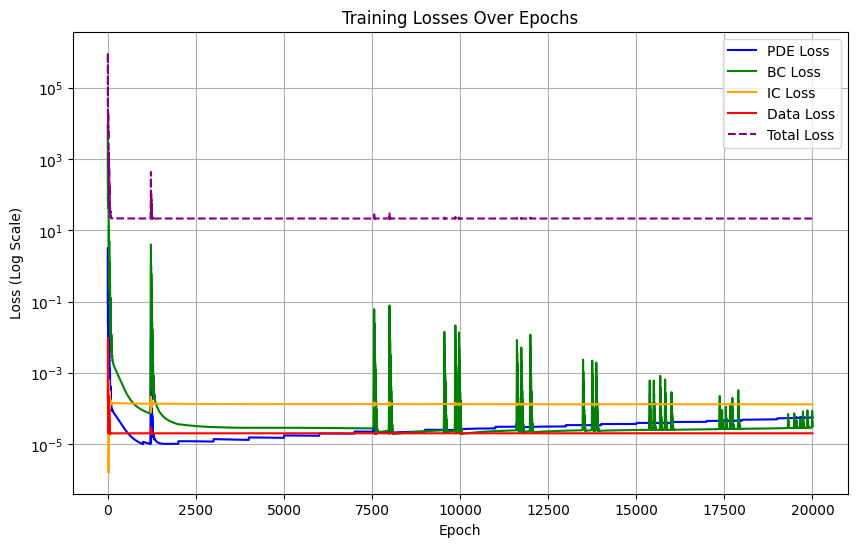

In [34]:
# Plot all losses
plt.figure(figsize=(10, 6))
plt.plot(losses_pde, label="PDE Loss", color='blue')
plt.plot(losses_bc, label="BC Loss", color='green')
plt.plot(losses_ic, label="IC Loss", color='orange')
plt.plot(losses_data, label="Data Loss", color='red')
plt.plot(losses_total, label="Total Loss", color='purple', linestyle='--')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('training_losses.png')
plt.show()

### 11. Save the Model

This cell saves the trained model.

In [18]:
# Save the model
torch.save(model.state_dict(), 'reservoir_pinn.pth')
print("Model saved as 'reservoir_pinn.pth'")


Model saved as 'reservoir_pinn.pth'


### 12. Validate Model

This cell computes the MSE and compares predictions.

In [19]:
# Validation: Compute MSE and print predictions
with torch.no_grad():
    p_d_pred = model(inputs_d)
    mse_data = torch.mean(((p_d_pred - p_d) / p_scale)**2).item()
    print(f"Final MSE on sparse data (normalized): {mse_data:.6f}")
    print("Predicted vs Actual pressures:")
    for i in range(N_d):
        print(f"Point {i+1}: Predicted={p_d_pred[i].item():.2f}, Actual={p_d[i].item():.2f}")

# Explanation of cells:
# - torch.no_grad(): Disables gradient tracking.
# - p_d_pred: Predicts pressure at 50 data points.
# - mse_data: Computes normalized MSE.
# - Prints MSE and predicted vs. actual pressures.

Final MSE on sparse data (normalized): 0.000020
Predicted vs Actual pressures:
Point 1: Predicted=1012.39, Actual=1010.00
Point 2: Predicted=1012.32, Actual=1020.00
Point 3: Predicted=1012.02, Actual=1005.00
Point 4: Predicted=1011.99, Actual=1015.00
Point 5: Predicted=1012.25, Actual=1008.00
Point 6: Predicted=1011.17, Actual=1018.20
Point 7: Predicted=1011.64, Actual=1019.50
Point 8: Predicted=1012.03, Actual=1007.80
Point 9: Predicted=1012.20, Actual=1009.30
Point 10: Predicted=1012.35, Actual=1016.70
Point 11: Predicted=1012.37, Actual=1017.90
Point 12: Predicted=1012.35, Actual=1006.40
Point 13: Predicted=1012.18, Actual=1012.10
Point 14: Predicted=1012.01, Actual=1018.80
Point 15: Predicted=1011.80, Actual=1008.50
Point 16: Predicted=1011.42, Actual=1019.10
Point 17: Predicted=1011.84, Actual=1007.20
Point 18: Predicted=1012.09, Actual=1013.40
Point 19: Predicted=1012.29, Actual=1017.60
Point 20: Predicted=1012.39, Actual=1010.90
Point 21: Predicted=1012.34, Actual=1008.70
Point 

### 13. Test Loading the Model

This cell tests reloading the saved model.

In [20]:
# Test loading the saved model
def load_and_predict(model_class, model_path, inputs, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    with torch.no_grad():
        predictions = model(inputs)
    return predictions

loaded_predictions = load_and_predict(PINN, 'reservoir_pinn.pth', inputs_d, device)
print("Predictions from loaded model:")
for i in range(N_d):
    print(f"Point {i+1}: Loaded={loaded_predictions[i].item():.2f}, Actual={p_d[i].item():.2f}")


Predictions from loaded model:
Point 1: Loaded=1012.39, Actual=1010.00
Point 2: Loaded=1012.32, Actual=1020.00
Point 3: Loaded=1012.02, Actual=1005.00
Point 4: Loaded=1011.99, Actual=1015.00
Point 5: Loaded=1012.25, Actual=1008.00
Point 6: Loaded=1011.17, Actual=1018.20
Point 7: Loaded=1011.64, Actual=1019.50
Point 8: Loaded=1012.03, Actual=1007.80
Point 9: Loaded=1012.20, Actual=1009.30
Point 10: Loaded=1012.35, Actual=1016.70
Point 11: Loaded=1012.37, Actual=1017.90
Point 12: Loaded=1012.35, Actual=1006.40
Point 13: Loaded=1012.18, Actual=1012.10
Point 14: Loaded=1012.01, Actual=1018.80
Point 15: Loaded=1011.80, Actual=1008.50
Point 16: Loaded=1011.42, Actual=1019.10
Point 17: Loaded=1011.84, Actual=1007.20
Point 18: Loaded=1012.09, Actual=1013.40
Point 19: Loaded=1012.29, Actual=1017.60
Point 20: Loaded=1012.39, Actual=1010.90
Point 21: Loaded=1012.34, Actual=1008.70
Point 22: Loaded=1012.29, Actual=1006.30
Point 23: Loaded=1012.11, Actual=1016.20
Point 24: Loaded=1011.87, Actual=10

### 14. Visualize Pressure Field (Static)

This cell plots a 2D pressure slice at a fixed z-value.

In [36]:
# Visualization of pressure field (2D slice at z=0.5)
def plot_pressure_slice(model, t_val, z_val, data_df):
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, z_val)
    T = np.full_like(X, t_val)
    
    inputs = torch.tensor(np.stack([X.flatten(), Y.flatten(), Z.flatten(), T.flatten()], axis=1), 
                         dtype=torch.float32).to(device)
    with torch.no_grad():
        P = model(inputs).cpu().numpy().reshape(X.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, P, levels=20, cmap="viridis")
    plt.colorbar(label="Pressure (Pa)")
    mask = np.abs(data_df['z'] - z_val) < 0.1  # Points near z_val
    plt.scatter(data_df['x'][mask], data_df['y'][mask], c="red", label="Data points")
    plt.title(f"Pressure at z={z_val:.2f}, t={t_val:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.savefig(f"pressure_z_{z_val:.2f}_t_{t_val:.2f}.png")
    plt.close()

# Plot slices at different times
plot_pressure_slice(model, 0.0, 0.5, data_df)
plot_pressure_slice(model, 0.5, 0.5, data_df)
plot_pressure_slice(model, 1.0, 0.5, data_df)

# Explanation of cells:
# - plot_pressure_slice: Plots a 2D pressure slice at fixed z and t.
# - X, Y, Z, T: Meshgrid for x, y with constant z and t.
# - inputs: 4D tensor for model prediction.
# - P: Predicted pressures reshaped to 2D grid.
# - Plot: Contour plot with data points near z_val, saved as PNG.
# - Calls: Plots at t=0.0, 0.5, 1.0 for z=0.5.

### 15. Visualize Pressure Field (Animation)

This cell generates an animation of a 2D pressure slice over time.

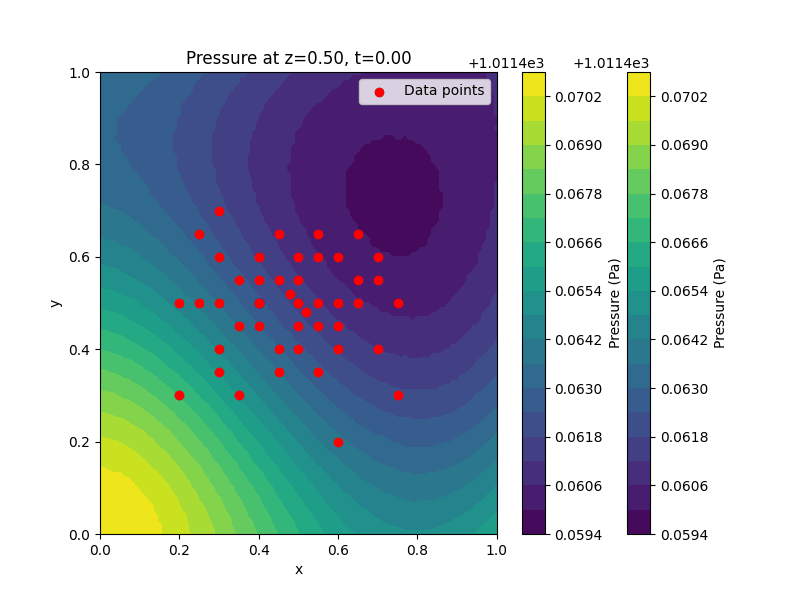

In [37]:
def animate_pressure_slice(model, data_df, z_val, device, p_scale=1000.0, p_base=1000.0, filename='pressure_animation.gif'):
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.full_like(X, z_val)
    times = np.linspace(0, 1, 50)

    fig, ax = plt.subplots(figsize=(8, 6))
    inputs = torch.tensor(np.stack([X.flatten(), Y.flatten(), Z.flatten(), np.zeros_like(X.flatten())], axis=1), 
                         dtype=torch.float32).to(device)

    def update(frame):
        ax.clear()
        t_val = times[frame]
        inputs[:, 3] = t_val
        try:
            with torch.no_grad():
                P = model(inputs).cpu().numpy().reshape(X.shape)  # Adjusted to not pass p_scale, p_base directly
        except Exception as e:
            print(f"Error in frame {frame}: {e}")
            return []
        contour = ax.contourf(X, Y, P, levels=20, cmap="viridis")
        mask = np.abs(data_df['z'] - z_val) < 0.1
        scatter = ax.scatter(data_df['x'][mask], data_df['y'][mask], c="red", label="Data points")
        ax.set_title(f"Pressure at z={z_val:.2f}, t={t_val:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()
        if frame == 0:
            fig.colorbar(contour, ax=ax, label="Pressure (Pa)")
        return [contour, scatter]

    try:
        anim = FuncAnimation(fig, update, frames=len(times), interval=100, blit=False)
        anim.save(filename, writer='pillow', fps=10)
    except Exception as e:
        print(f"Error saving animation: {e}")
    finally:
        plt.close(fig)
    return filename

# Generate and display animation
animation_file = animate_pressure_slice(model, data_df, 0.5, device)
with open(animation_file, 'rb') as f:
    display(Image(data=f.read(), format='gif'))